<div style='text-align: center;'>
    <h1>CS6910 Fundamentals of Deep Learning</h1>
    <h2>Assignment-1</h2>
</div>

In [1]:
# Load all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
from sklearn.model_selection import train_test_split

In [22]:
#Random seed to initiate initial weights and bias.
#This decides the overall convergence of the model.
np.random.seed(27)

In [23]:
class ObjectiveFunction:
    def __init__(self, method):
        self.method = method

    def get_loss(self, y, y_hat):
        if self.method == "cel":
            return self.cross_entropy_loss(y, y_hat)
        elif self.method == "mse":
            return self.mean_square_error(y, y_hat)

    def get_derivative(self, y, y_hat):
        if self.method == "cel":
            return self.cross_entropy_loss_derivative(y, y_hat)
        elif self.method == "mse":
            return self.mean_square_error_derivative(y, y_hat)

    def mean_square_error(self, y, y_hat):
        return np.sum((y - y_hat) ** 2) / 2

    def mean_square_error_derivative(self, y, y_hat):
        return y_hat - y

    def cross_entropy_loss(self, y, y_hat):
        return -np.sum(y * np.log(y_hat))

    def cross_entropy_loss_derivative(self, y, y_hat):
        return -y/y_hat

In [24]:
class NeuralLayer:
    def __init__(self, index, n_input, n_neurons, function=None, weights=None, bias=None, method="random"):
        self.index = index
        self.function = function if function is not None else 'sigmoid'
        self.weights = weights if weights is not None else self.initialize_weights(method, n_input, n_neurons)
        self.bias = bias if bias is not None else np.random.randn(n_neurons)
        self.activation = None

        self.error = None
        self.delta = None

        self.d_weights = np.zeros([n_input, n_neurons])
        self.d_bias = np.zeros(n_neurons)

        self.h_weights = np.zeros([n_input, n_neurons])
        self.h_bias = np.zeros(n_neurons)
        self.m_weights = np.zeros([n_input, n_neurons])
        self.m_bias = np.zeros(n_neurons)

    def initialize_weights(self, method, n_input, n_neurons):
        if method == "xavier":
            limit = np.sqrt(2 / (n_input + n_neurons))
            return np.random.randn(n_input, n_neurons) * limit
        return np.random.randn(n_input, n_neurons)

    def activate(self, x):
        z = np.dot(x, self.weights) + self.bias
        self.activation = self._apply_activation(z)
        return self.activation

    def _apply_activation(self, r):
        if self.function == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        elif self.function == 'tanh':
            return np.tanh(r)
        elif self.function == 'relu':
            return np.maximum(0, r)
        elif self.function == 'softmax':
            max_r = np.max(r, axis=1)
            max_r = max_r.reshape(max_r.shape[0], 1)
            exp_r = np.exp(r - max_r)
            return exp_r / np.sum(exp_r, axis=1).reshape(exp_r.shape[0], 1)
        return r

    def apply_activation_derivative(self, z):
        if self.function == 'sigmoid':
            return z * (1 - z)
        elif self.function == 'tanh':
            return (z - z**2)
        elif self.function == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.function == 'softmax':
            return np.diag(z) - np.outer(z, z)
        return np.ones(z.shape)

    def __str__(self):
        return f'Neural Layer: {self.index}, {self.weights.shape} , {self.function}'

In [25]:
class NeuralNetwork:
    def __init__(self, config):
        def get_value(key, default):
            return config[key] if key in config else default

        self.layers = []

        self.criterion = get_value('criterion', 'cel')
        self.weight_initialization = get_value('weight_initialization', 'random')

        self.c = ObjectiveFunction(method=self.criterion)

        self.add_layers(config['input_size'],
                         config['hidden_layers'],
                         config['output_size'],
                         config['neurons'],
                         config['activation'],
                         config['output_activation']
                        )

    def forward(self, x):
        for layer in self.layers:
            x = layer.activate(x)
        return x

    def backward(self, x, y, y_hat):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if layer == self.layers[-1]:
                layer.error = self.c.get_derivative(y, y_hat)
                output_derivative_matrix = []
                for i in range(y_hat.shape[0]):
                    output_derivative_matrix.append(np.matmul(
                        self.c.get_derivative(y[i], y_hat[i]),
                        layer.apply_activation_derivative(y_hat[i])
                    ))
                layer.delta = np.array(output_derivative_matrix)
            else:
                next_layer = self.layers[i + 1]
                layer.error = np.matmul(next_layer.delta, next_layer.weights.T)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.activation)


        for i in range(len(self.layers)):
            layer = self.layers[i]
            activation = np.atleast_2d(x if i == 0 else self.layers[i - 1].activation)
            layer.d_weights = np.matmul(activation.T, layer.delta)/y.shape[0]
            layer.d_bias = np.sum(layer.delta, axis=0)/y.shape[0]

    def add_layers(self, input_size, hidden_layers, output_size, neurons, activation, output_activation):
        for i in range(0, hidden_layers+1):
            n_input = input_size if i==0 else neurons
            n_neurons = output_size if i==hidden_layers else neurons
            self.layers.append(NeuralLayer(
                index=i+1,
                n_input=n_input,
                n_neurons=n_neurons,
                function= output_activation if i==hidden_layers else activation,
                method=self.weight_initialization
                )
            )

In [26]:
class Optimizer:
    def __init__(self, nn:NeuralNetwork, config=None):
        self.nn, self.lr, self.optimizer = nn, config['learning_rate'], config['optimizer']
        self.beta, self.epsilon, self.beta1, self.beta2= config['beta'], config['epsilon'], config['beta1'], config['beta2']
        self.timestep = 0
        self.decay = config['decay']

    def step(self):
        if(self.optimizer == "sgd"):
            self.sgd()
        elif(self.optimizer == "momentum"):
            self.momentum()
        elif(self.optimizer == "nag"):
            self.nag()
        elif(self.optimizer == "rmsprop"):
            self.rmsprop()
        elif(self.optimizer == "adam"):
            self.adam()
        elif (self.optimizer == "nadam"):
            self.nadam()

    def sgd(self):
        for layer in self.nn.layers:
            layer.weights -= self.lr*(layer.d_weights + self.decay*layer.weights)
            layer.bias -= self.lr*(layer.d_bias + self.decay*layer.bias)

    def momentum(self):
        for layer in self.nn.layers:
            layer.h_weights = self.beta*layer.h_weights + layer.d_weights
            layer.h_bias = self.beta*layer.h_bias + layer.d_bias
            layer.weights -= self.lr*(layer.h_weights + self.decay*layer.weights)
            layer.bias -= self.lr*(layer.h_bias + self.decay*layer.bias)

    def nag(self):
        for layer in self.nn.layers:
            layer.h_weights = self.beta*layer.h_weights + layer.d_weights
            layer.h_bias = self.beta*layer.h_bias + layer.d_bias
            layer.weights -= self.lr * (self.beta * layer.h_weights + layer.d_weights + self.decay * layer.weights)
            layer.bias -= self.lr * (self.beta * layer.h_bias + layer.d_bias + self.decay * layer.bias)

    def rmsprop(self):
        for layer in self.nn.layers:
            layer.h_weights = self.beta * layer.h_weights + (1 - self.beta) * layer.d_weights**2
            layer.h_bias = self.beta * layer.h_bias + (1 - self.beta) * layer.d_bias**2
            layer.weights -= (self.lr / (np.sqrt(layer.h_weights) + self.epsilon)) * layer.d_weights + self.decay * layer.weights * self.lr
            layer.bias -= (self.lr / (np.sqrt(layer.h_bias) + self.epsilon)) * layer.d_bias + self.decay * layer.bias * self.lr

    def adam(self):
        for layer in self.nn.layers:
            layer.m_weights = self.beta1 * layer.m_weights + (1 - self.beta1) * layer.d_weights
            layer.m_bias = self.beta1 * layer.m_bias + (1 - self.beta1) * layer.d_bias
            layer.h_weights = self.beta2 * layer.h_weights + (1 - self.beta2) * layer.d_weights**2
            layer.h_bias = self.beta2 * layer.h_bias + (1 - self.beta2) * layer.d_bias**2
            correction_term1 = 1/(1 - self.beta1**(self.timestep + 1))
            correction_term2 = 1/(1 - self.beta2**(self.timestep + 1))
            weights_hat1 = layer.m_weights * correction_term1
            bias_hat1 = layer.m_bias * correction_term1
            weights_hat2 = layer.h_weights * correction_term2
            bias_hat2 = layer.h_bias * correction_term2
            layer.weights -= self.lr * (weights_hat1 / ((np.sqrt(weights_hat2)) + self.epsilon)) + self.decay * layer.weights * self.lr
            layer.bias -= self.lr * (bias_hat1 / ((np.sqrt(bias_hat2)) + self.epsilon)) + self.decay * layer.bias * self.lr

    def nadam(self):
        for layer in self.nn.layers:
            layer.m_weights = self.beta1 * layer.m_weights + (1 - self.beta1) * layer.d_weights
            layer.m_bias = self.beta1 * layer.m_bias + (1 - self.beta1) * layer.d_bias
            layer.h_weights = self.beta2 * layer.h_weights + (1 - self.beta2) * layer.d_weights**2
            layer.h_bias = self.beta2 * layer.h_bias + (1 - self.beta2) * layer.d_bias**2
            correction_term1 = 1/(1 - self.beta1**(self.timestep + 1))
            correction_term2 = 1/(1 - self.beta2**(self.timestep + 1))
            weights_hat1 = layer.m_weights * correction_term1
            bias_hat1 = layer.m_bias * correction_term1
            weights_hat2 = layer.h_weights * correction_term2
            bias_hat2 = layer.h_bias * correction_term2
            combined_weight_update = self.beta1 * weights_hat1 + ((1 - self.beta1) / (1 - self.beta1 ** (self.timestep + 1))) * layer.d_weights
            combined_bias_update = self.beta1 * bias_hat1 + ((1 - self.beta1) / (1 - self.beta1 ** (self.timestep + 1))) * layer.d_bias
            layer.weights -= self.lr * (combined_weight_update / ((np.sqrt(weights_hat2)) + self.epsilon)) + self.decay * layer.weights * self.lr
            layer.bias -= self.lr * (combined_bias_update / ((np.sqrt(bias_hat2)) + self.epsilon)) + self.decay * layer.bias * self.lr

In [27]:
# Load Input Data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Flatten the images
train_images = train_images.reshape(train_images.shape[0], 784) / 255
X_test = test_images.reshape(test_images.shape[0], 784) / 255

# Encode the labels
train_labels = np.eye(10)[train_labels]
Y_test = np.eye(10)[test_labels]

# Prepare data for training and validation
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True, random_state=27)

In [28]:
def accuracy(y, y_hat):
    accuracy = np.mean(np.argmax(y, axis=1)==np.argmax(y_hat, axis=1))
    return accuracy

In [29]:
def train(config):
    train_loss_hist = []
    train_accuracy_hist = []
    val_loss_hist = []
    val_accuracy_hist = []
    
    nn = NeuralNetwork(config)
    optimizer = Optimizer(nn=nn, config=config)
    
    batch_size = config['batch_size']
    criterion = ObjectiveFunction(method = config['criterion'])
    
    for epoch in range(config['epochs']):
        for batch in range(0, X_train.shape[0], batch_size):
            # Get the batch of data
            X_batch = X_train[batch:batch+batch_size]
            Y_batch = Y_train[batch:batch+batch_size]

            Y_hat_batch = nn.forward(X_batch)
            nn.backward(X_batch, Y_batch, Y_hat_batch)
            optimizer.step()
        
        optimizer.timestep += 1
        
        # Training
        Y_hat_train = nn.forward(X_train)
        train_loss = criterion.get_loss(Y_train, Y_hat_train)
        train_accuracy = np.sum(np.argmax(Y_hat_train, axis=1) == np.argmax(Y_train, axis=1)) / Y_train.shape[0]
            
        # Validation
        Y_hat_val = nn.forward(X_val)
        val_loss = criterion.get_loss(Y_val, Y_hat_val)
        val_accuracy = np.sum(np.argmax(Y_hat_val, axis=1) == np.argmax(Y_val, axis=1)) / Y_val.shape[0]
        
        print("Epoch {} Train Loss {} Train Accuracy {} Val Loss {} Val Accuracy {}".format(epoch, train_loss, train_accuracy, val_loss, val_accuracy))
   
        train_loss_hist.append(train_loss)
        train_accuracy_hist.append(train_accuracy)
        val_loss_hist.append(val_loss)
        val_accuracy_hist.append(val_accuracy)
    
    return nn

In [36]:
network_config = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': 5,
    'neurons':128,
    'activation':'relu',
    'output_activation':'softmax',
    'learning_rate': 0.01,
    'beta': 0.8,
    'beta1': 0.9,
    'beta2':0.9999,
    'epsilon': 1e-8,
    'epochs': 10,
    'optimizer': "adam",
    'criterion': "cel",
    'decay': 0.0005,
    'weight_initialization': "xavier",
    'batch_size': 64,
}

In [37]:
nn = train(network_config)

Epoch 0 Train Loss 22464.704269970338 Train Accuracy 0.8501851851851852 Val Loss 2726.2918552676097 Val Accuracy 0.8373333333333334
Epoch 1 Train Loss 19494.264216627376 Train Accuracy 0.8676481481481482 Val Loss 2428.896002180486 Val Accuracy 0.8495
Epoch 2 Train Loss 18227.718732715344 Train Accuracy 0.8758148148148148 Val Loss 2354.5164141281066 Val Accuracy 0.8541666666666666
Epoch 3 Train Loss 17260.85392752606 Train Accuracy 0.8810740740740741 Val Loss 2292.619953840376 Val Accuracy 0.8588333333333333
Epoch 4 Train Loss 16783.007776580016 Train Accuracy 0.8844444444444445 Val Loss 2291.3624426331066 Val Accuracy 0.8608333333333333
Epoch 5 Train Loss 16058.716379354459 Train Accuracy 0.889462962962963 Val Loss 2250.293376087364 Val Accuracy 0.8628333333333333
Epoch 6 Train Loss 15623.711566201597 Train Accuracy 0.8926666666666667 Val Loss 2226.6460786820658 Val Accuracy 0.8675
Epoch 7 Train Loss 15242.908048613941 Train Accuracy 0.8952592592592593 Val Loss 2219.099459299869 Val Ac

In [13]:
wandb.login(key='5da0c161a9c9720f15195bb6e9f05e44c45112d1')
wandb.init(project="CS6910_AS1", entity='ed23s037')
wandb.config.update(network_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ravig\.netrc
wandb: Currently logged in as: ed23s037. Use `wandb login --relogin` to force relogin


In [15]:
y_pred_train = nn.forward(X_train)
y_pred_test = nn.forward(X_test)

y_true_train = np.argmax(Y_train, axis=1)
y_true_test = np.argmax(Y_test, axis=1)
preds_train = np.argmax(y_pred_train, axis=1)
preds_test = np.argmax(y_pred_test, axis=1)

In [16]:
# Class Names
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Confusion Matrix Plot
wandb.log({'confusion_matrix_train': wandb.plot.confusion_matrix(probs=None, y_true=y_true_train, preds=preds_train, class_names=CLASS_NAMES)})
wandb.log({'confusion_matrix': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=preds_test, class_names=CLASS_NAMES)})

wandb.log({'confusion_matrix_sklearn': wandb.sklearn.plot_confusion_matrix(y_true_test, preds_test, CLASS_NAMES)})

wandb.finish()

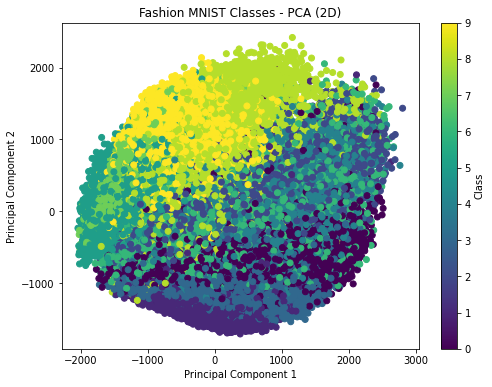

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Optional: Flatten the images if they are not already flattened
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 1. Dimensionality Reduction with PCA and Scatter Plot

# Reduce dimensions to 2 for visualization (you can adjust this)
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# Create a scatter plot of the PCA transformed data
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title("Fashion MNIST Classes - PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Class')
plt.show()